### Neural Style Transfer

In this notebook, I experimented 2 types of networks:
- VGG19
- Alexnet

With 2 types of pooling method:
- Max Pool
- Average Pool

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import random
import cv2
import matplotlib.pyplot as plt

import copy
from scipy import ndimage

In [3]:
!wget https://uploads4.wikiart.org/images/wifredo-lam/le-sombre-malembo-dieu-du-carrefour-1943.jpg

--2018-06-26 03:11:45--  https://uploads4.wikiart.org/images/wifredo-lam/le-sombre-malembo-dieu-du-carrefour-1943.jpg
Resolving uploads4.wikiart.org (uploads4.wikiart.org)... 95.211.148.46
Connecting to uploads4.wikiart.org (uploads4.wikiart.org)|95.211.148.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120841 (118K) [image/jpg]
Saving to: ‘le-sombre-malembo-dieu-du-carrefour-1943.jpg’

le-sombre-malembo-d 100%[===================>] 118.01K   319KB/s    in 0.4s    

2018-06-26 03:11:46 (319 KB/s) - ‘le-sombre-malembo-dieu-du-carrefour-1943.jpg’ saved [120841/120841]



In [5]:
!mv le-sombre-malembo-dieu-du-carrefour-1943.jpg lam2.jpg

In [9]:
!wget http://img.wxcha.com/file/201606/27/a6555e559d.jpg

--2018-06-26 03:18:24--  http://img.wxcha.com/file/201606/27/a6555e559d.jpg
Resolving img.wxcha.com (img.wxcha.com)... 218.75.155.230
Connecting to img.wxcha.com (img.wxcha.com)|218.75.155.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7220 (7.1K) [image/jpeg]
Saving to: ‘a6555e559d.jpg’

a6555e559d.jpg      100%[===================>]   7.05K  7.00KB/s    in 1.0s    

2018-06-26 03:18:26 (7.00 KB/s) - ‘a6555e559d.jpg’ saved [7220/7220]



In [10]:
!mv a6555e559d.jpg panda.jpg

### Read Picture

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

(545, 450, 3)

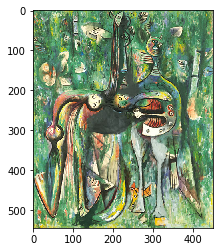

In [4]:
path = "./lam2.jpg"
im1 = read_image(path)
fig2 = plt.figure(figsize = (4,4)) 
plt.imshow(im1)
im1.shape

(200, 200, 3)

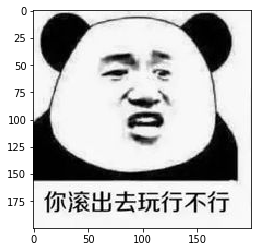

In [5]:
path = "./panda.jpg"
im2 = read_image(path)
fig2 = plt.figure(figsize = (4,4)) 
plt.imshow(im2)
im2.shape

In [6]:
im3 = im2[0:160, 0:190]

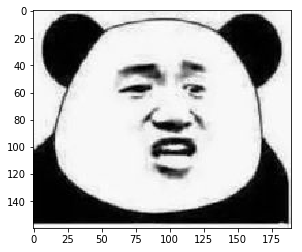

In [7]:
plt.imshow(im3)

### Preprocessing
We need style and content images of the same size.

In [8]:
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

In [9]:
sz = 227
im4 = center_crop(im3)
im5 = cv2.resize(im4, (sz, sz))

In [10]:
im1 = center_crop(im1)
im1 = cv2.resize(im1, (sz, sz))

In [11]:
def transform_images(im):
    """ Transform images to be ready for vgg"""
    im = np.rollaxis(im, 2)
    im = im[None]
    return torch.tensor(im, dtype=torch.float32).cuda()

In [43]:
style_img = transform_images(im1/255)
content_img = transform_images(im5/255)

In [13]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

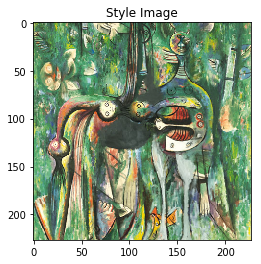

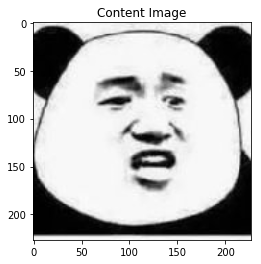

In [14]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

### Content Loss

In [15]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

In [16]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [17]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Cuda

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load the neural network

In [20]:
cnn = models.alexnet(pretrained=True).features.to(device).eval()

In [21]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [28]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               pool='max', pool_size = (2,2), pool_stride = (2,2)):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            if pool == 'avg':
                layer = nn.AvgPool2d(kernel_size=pool_size, stride=pool_stride)
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### Input Image

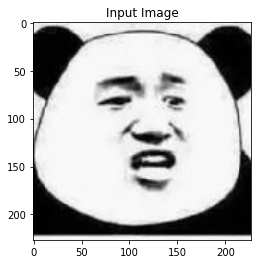

In [29]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [44]:
def load_img():
    style_img = transform_images(im1/255)
    content_img = transform_images(im5/255)
    input_img = content_img.clone()
    return style_img, content_img, input_img

### Gradient Descent

In [30]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [47]:
def run_style_transfer(content_img, style_img, input_img, cnn_type='alex', 
                       pool='max', pool_size=(2,2), pool_stride=(2,2),
                       num_steps=300, style_weight=1000000, content_weight=1):
    
    normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    """Run the style transfer."""
    print('Loading {}...'.format(cnn_type))
    
    if cnn_type == 'alex':
        cnn = models.alexnet(pretrained=True).features.to(device).eval()
    elif cnn_type == 'vgg':
        cnn = models.vgg19(pretrained=True).features.to(device).eval()
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, 
        pool=pool, pool_size=pool_size, pool_stride=pool_stride)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [52]:
style_img, content_img, input_img = load_img()

alex_max = run_style_transfer(content_img, style_img, input_img, cnn_type='alex',
                                pool='max', pool_size=(3,3), pool_stride=(2,2))

Loading alex...
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6358.949219 Content Loss: 76.640511

run [100]:
Style Loss : 2374.166260 Content Loss: 85.328468

run [150]:
Style Loss : 1334.266846 Content Loss: 87.557602

run [200]:
Style Loss : 886.694519 Content Loss: 87.468193

run [250]:
Style Loss : 640.171204 Content Loss: 87.522758

run [300]:
Style Loss : 507.596283 Content Loss: 87.155518



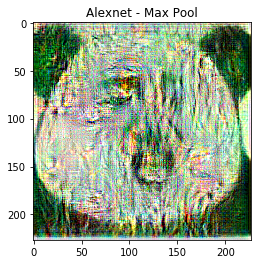

In [58]:
plt.figure()
imshow(alex_max, title='Alexnet - Max Pool')

sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [54]:
style_img, content_img, input_img = load_img()

alex_avg = run_style_transfer(content_img, style_img, input_img, cnn_type='alex',
                                pool='avg', pool_size=(3,3), pool_stride=(2,2))

Loading alex...
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 33.754749 Content Loss: 6.500418

run [100]:
Style Loss : 5.143740 Content Loss: 6.047170

run [150]:
Style Loss : 2.464608 Content Loss: 5.860713

run [200]:
Style Loss : 1.730687 Content Loss: 5.711350

run [250]:
Style Loss : 1.381312 Content Loss: 5.596867

run [300]:
Style Loss : 1.199959 Content Loss: 5.501999



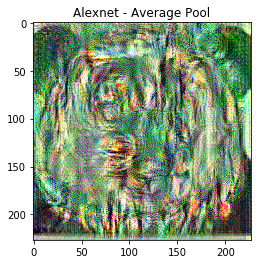

In [55]:
plt.figure()
imshow(alex_avg, title='Alexnet - Average Pool')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [56]:
style_img, content_img, input_img = load_img()

vgg_max = run_style_transfer(content_img, style_img, input_img, cnn_type='vgg',
                             pool='max', pool_size=(2,2), pool_stride=(2,2))

Loading vgg...
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 163.119781 Content Loss: 58.836205

run [100]:
Style Loss : 29.156975 Content Loss: 57.684940

run [150]:
Style Loss : 11.637362 Content Loss: 55.769207

run [200]:
Style Loss : 6.619049 Content Loss: 53.262012

run [250]:
Style Loss : 4.767799 Content Loss: 50.978542

run [300]:
Style Loss : 3.765304 Content Loss: 49.075764



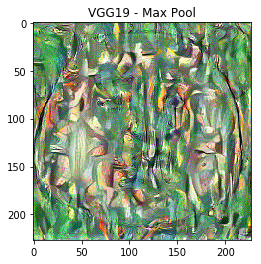

In [62]:
plt.figure()
imshow(vgg_max, title='VGG19 - Max Pool')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [60]:
style_img, content_img, input_img = load_img()

vgg_avg = run_style_transfer(content_img, style_img, input_img, cnn_type='vgg',
                             pool='avg', pool_size=(2,2), pool_stride=(2,2))

Loading vgg...
Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.134895 Content Loss: 21.606943

run [100]:
Style Loss : 1.262254 Content Loss: 18.160749

run [150]:
Style Loss : 0.917704 Content Loss: 16.858393

run [200]:
Style Loss : 0.812308 Content Loss: 16.288286

run [250]:
Style Loss : 0.766834 Content Loss: 15.906294

run [300]:
Style Loss : 0.738437 Content Loss: 15.693292



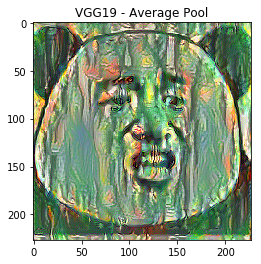

In [61]:
plt.figure()
imshow(vgg_avg, title='VGG19 - Average Pool')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()